## Investigation Overview

Bike rental demand tends to vary along three attributes: station, gender, and day of the week. These three attributes are important factors in ensuring that the supply of bike rentals meets customer demand. Each individual station must contain an adequate supply of bikes to meet the demand of users at that station on any particular day. Gender can also be generalized to anticipate what size bikes should be stocked at a particular station to meet general differences in bike sizing for different genders. These factors can provide key insights into ensuring that the bike sharing stations provide adequate supply for their customers.


## Dataset Overview

The bike sharing dataset includes information about individual rides made in a bike-sharing system covering the greater San Francisco Bay area. The datas used in this analysis is limited to February 1, 2019 to March 1, 2019. 

In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [3]:
# get the dat of week from a date time
def get_day_of_week(df, col):
    df['day_of_week'] = df[col].dt.day_of_week
    # make a list of days of week to replace the numbers (0-6) generated from the dt.day_of_week
    days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    # replace the numbered values with the strings of the days of the week
    df['day_of_week'] = df.day_of_week.replace(to_replace=[0, 1, 2, 3, 4, 5, 6], value=days_of_week)
    # make the days categorical types
    days = pd.api.types.CategoricalDtype(ordered=True, categories=days_of_week)
    # cast the days of week column as the days categorical type
    return df['day_of_week'].astype(days)

In [4]:
# Perform all the data wrangling and feature engineering needed for the visualizations

# load the data and parse date columns as datetimes
bike_raw = pd.read_csv("data/201902-fordgobike-tripdata.csv", parse_dates=["start_time", "end_time"])
# drop the features that won't be explored
bike = bike_raw.drop(labels=['start_station_id', 'end_station_id'], axis=1)
# get the day of the week from the datetime
bike["day_of_week"] = get_day_of_week(bike, "start_time")

## Rental Trends Throughout the Week

Bike rental frequencies are relatively consistent throughout the weekdays, but decrease during the weekend. This suggests that weekday traffic to the stations should be used to determine the supply of bikes since the weekdays are when rentals peak. However, we need more information to determine the proper sizing of bikes needed (based on gender size generalizations) and what supply is needed for each station.

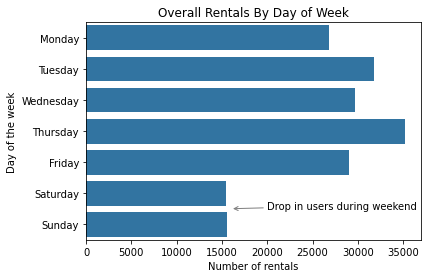

In [6]:
g = sns.countplot(data=bike, y="day_of_week", color=sns.color_palette()[0]);

g.set_title("Overall Rentals By Day of Week");
g.set(xlabel="Number of rentals", ylabel="Day of the week");
g.annotate("Drop in users during weekend", xy=(16000, 5.5), xytext = (20000, 5.5), arrowprops = {"arrowstyle":"->", "color":"gray"});

## User Genders

A majority of the users in the month of data were male. There is still a significant portion of female riders and a small portion of riders who identified as other. This information, if it were broken down by station, can be useful in determining the sizing of bikes that are needed to meet customer demand.

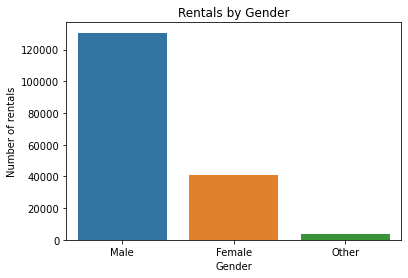

In [7]:
g = sns.countplot(data=bike, x="member_gender", order = bike['member_gender'].value_counts().index);
g.set_title("Rentals by Gender");
g.set(ylabel="Number of rentals", xlabel="Gender");

## Station Demand

By taking our data on bike rentals per week and gender breakdown of users and combining it with information on the stations, we can visualize the mean number of bikes that are needed at each station for each day of the week and the bike sizes that are needed (using generalizations on gender size). For example, we can see from the visualization below that on Mondays at the Berry St at 4th station, there should be stock to accomadate an average of around 80 rentals for bikes that should be generally sized for males. We can also see the standard error which can give a range, in this case around 50 to 115 rentals, which provides information on how we can expect the number of rentals to vary for that day. This overview of the data can be vital for the company to ensure that the stations are stocked daily to meet the demand of their expected customers. 

In [9]:
# Perform feature engineering needed for visualization

# get the date for each rental
bike["date"] = bike.start_time.dt.floor("D")
# count the number of rentals for each date, station, and gender
bike_rentals = bike.groupby(["start_station_name", "member_gender", "date"]).agg(num_rentals = ('start_time', 'count')).reset_index()
# get day of week for each date
bike_rentals["day_of_week"] = get_day_of_week(bike_rentals, "date")
# get the six stations with the most total rentals
top_six_stations = bike_rentals.groupby("start_station_name").num_rentals.sum().reset_index().sort_values("num_rentals", ascending=False).head(6).start_station_name.values 
# filter the bike rentals for the top six stations
top_six_station_rentals = bike_rentals[bike_rentals["start_station_name"].isin(top_six_stations)]

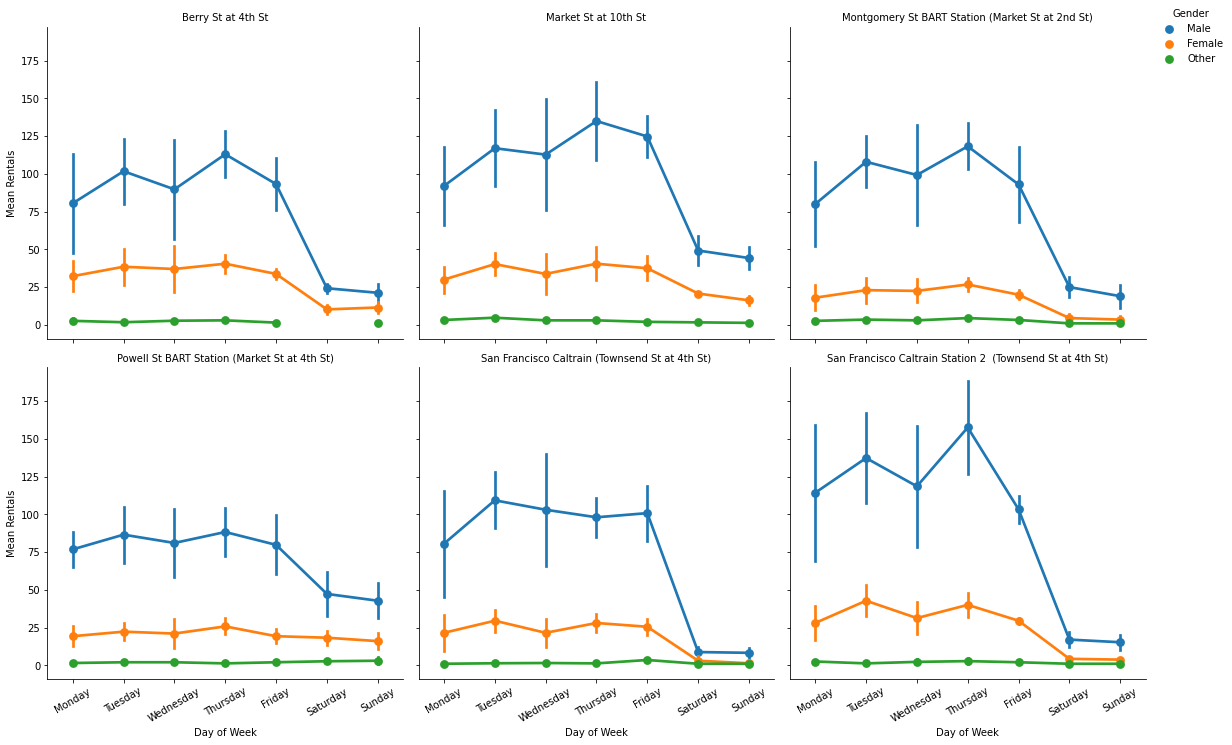

In [12]:
g = sns.catplot(
    data=top_six_station_rentals, 
    x="day_of_week", y="num_rentals", 
    hue="member_gender", kind="point",
    hue_order=["Male", "Female", "Other"],
    col="start_station_name", 
    col_wrap=3,
    ci="sd"
);
g.legend.remove();
g.add_legend(title="Gender");
sns.move_legend(g, "upper right");
g.set_titles(col_template="{col_name}");
g.set(xlabel="Day of Week", ylabel="Mean Rentals");
g.set_xticklabels(rotation=30);

## Summary

This analysis found bike-sharing trends among days of the week, gender, and stations that may help inform decisions to ensure bike rental stations are properly stocked to meet customer demand. Based on the data, we found that we can typically expect a drop in rentals during the weekend, which may suggest that many rentals are used for work commutes. Using data for which station the rentals occurred and the gender of the renter, we are able to determine how we can expect rentals vary by day of the week for each gender and station. Using this information, we have constructed an expectation for the amount of rental traffic that must be accounted for when stocking bike stations. 

Given these conclusions, because this data only contains rentals in the month of February, the insights found in this analysis may not hold in other months of the year. We may expect to see different results if we were to analyze a month in the summer when the weather is warmer and many of these trends may differ if we analyzed data from another city. Further analysis using the rental end times to determine net rented/returned across station may also be useful in providing more insight to help meet customer rental demand.
